# Trabajo Práctico N6. Color

In [108]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [109]:
#Funciones auxiliares

def myplotimg (img,vmin=0,vmax=255,title=None):
  plt.imshow(img,cmap='gray', vmin=vmin, vmax=vmax)
  if title != None:
    plt.title(title)
  plt.axis("off")
  plt.show()
  return

def show_side_by_side(imgs, subtitles = None, title = None, vmin=0, vmax=255, **kwargs):
    fig, axes = plt.subplots(1, len(imgs), **kwargs)
    if len(imgs) == 1:
        axes = [axes]
    if title is not None:
        fig.suptitle(title, y=0.8)
    if subtitles is None:
        subtitles = [None for _ in imgs]
    for ax, img, subtitle in zip(axes, imgs, subtitles):
        if subtitle is not None:
            ax.set_title(subtitle)
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), vmin=vmin, vmax=vmax)
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()

## 1)

In [110]:
def segment_ranges(img, ranges):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    final_mask = np.zeros(img.shape[:-1], dtype=np.uint8)

    for (start, end) in ranges:
        mask = cv2.inRange(hsv, start, end)
        final_mask = cv2.bitwise_or(final_mask, mask)

    return cv2.bitwise_and(img, img, mask=final_mask)

### a)

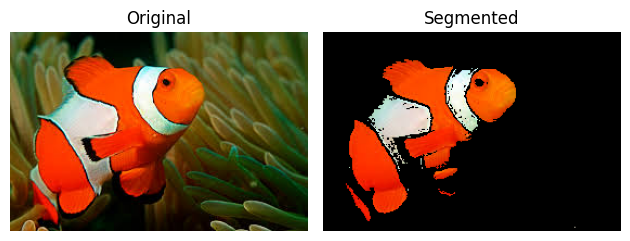

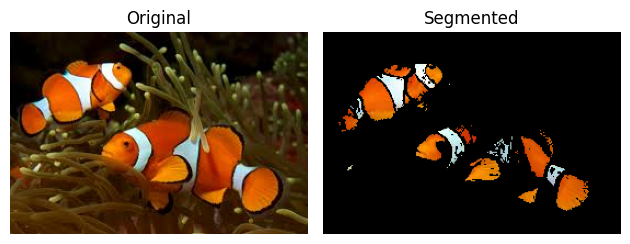

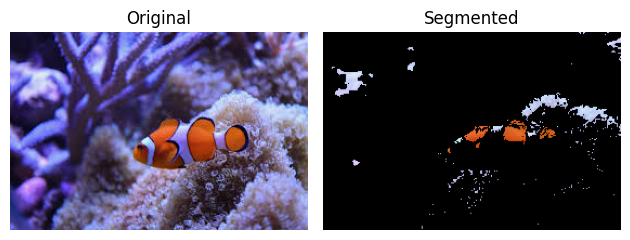

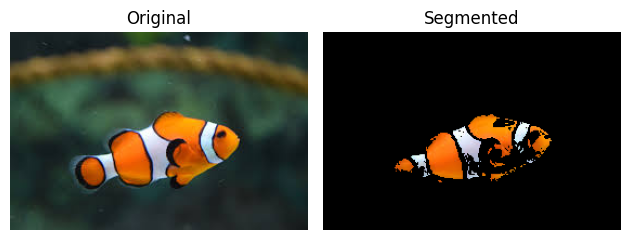

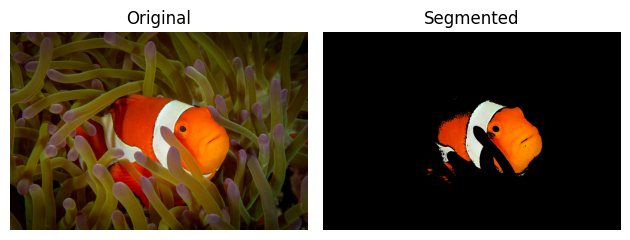

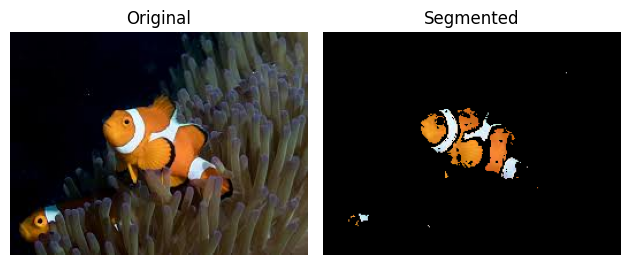

In [111]:
nemo_images = [cv2.imread(f"finding_nemo/images/nemo{n}.jpg") for n in range(6)]

def segment_nemo(img):
    light_orange = (18, 255, 255)
    dark_orange = (1, 190, 200)

    light_white = (145, 60, 255)
    dark_white = (0, 0, 200)

    return segment_ranges(img, ((dark_orange, light_orange), (dark_white, light_white)))

for nemo in nemo_images:
    show_side_by_side([nemo, segment_nemo(nemo)], ["Original", "Segmented"])

La ventaja de usar HSV en vez de RGB se dá en que es mas facil capturar un mismo tono bajo diferentes intensidades de luz al utilizar rangos en HSV.

### b)

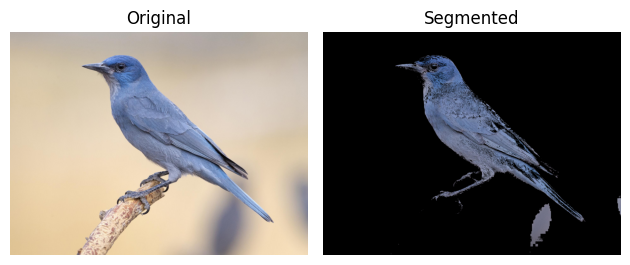

In [112]:
bird = cv2.imread("bird.jpg")

def segment_bird(img):
    dark = (107, 30, 65)
    light = (151, 161, 200)

    return segment_ranges(img, ((dark, light),))

show_side_by_side([bird, segment_bird(bird)], ["Original", "Segmented"])

### c)

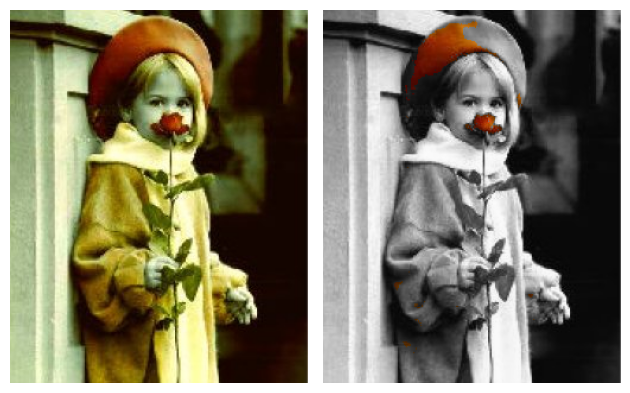

In [113]:
girl = cv2.imread('Girl_and_rose.jpg')
gray_girl = cv2.cvtColor(cv2.cvtColor(girl, cv2.COLOR_BGR2GRAY), cv2.COLOR_GRAY2BGR)

ranges = [((2, 215, 72),(16, 255, 213) )]

hsv = cv2.cvtColor(girl, cv2.COLOR_BGR2HSV)

rose_mask = np.zeros(girl.shape[:-1], dtype=np.uint8)

for (start, end) in ranges:
    mask = cv2.inRange(hsv, start, end)
    rose_mask = cv2.bitwise_or(rose_mask, mask)
background_mask = cv2.bitwise_not(rose_mask)

filtered_girl = cv2.bitwise_and(girl, girl, mask=rose_mask)
filtered_girl += cv2.bitwise_and(gray_girl, gray_girl, mask=background_mask)

show_side_by_side([girl, filtered_girl])

### d)

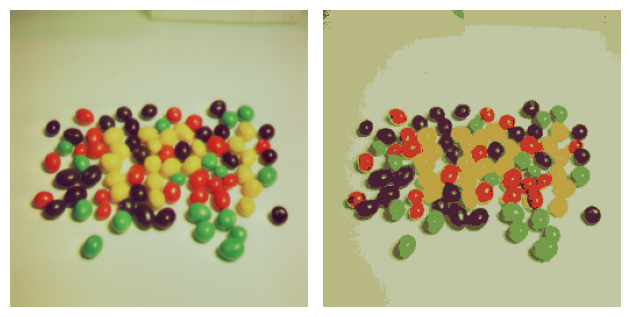

In [141]:
original_image = cv2.imread("beans.tiff")

img=cv2.cvtColor(original_image,cv2.COLOR_BGR2HSV)

vectorized = img.reshape((-1,3))

vectorized = np.float32(vectorized)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

K = 7
attempts=10
ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)

center = np.uint8(center)

res = center[label.flatten()]
result_image = res.reshape((img.shape))
result_image = cv2.cvtColor(result_image, cv2.COLOR_HSV2BGR)

show_side_by_side([original_image, result_image])